# Search Algorithms

## Part 8 - Networkx

In last section, there is another trap which makes our algorithms fail, for route 'V' to 'C'. Applicable to all of our BFS, DFS, UCS and A star so far, the cause is generic, because of a blind error we did from the beginning. 

Let us go ahead and try what happens with our A Star.

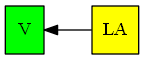

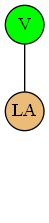

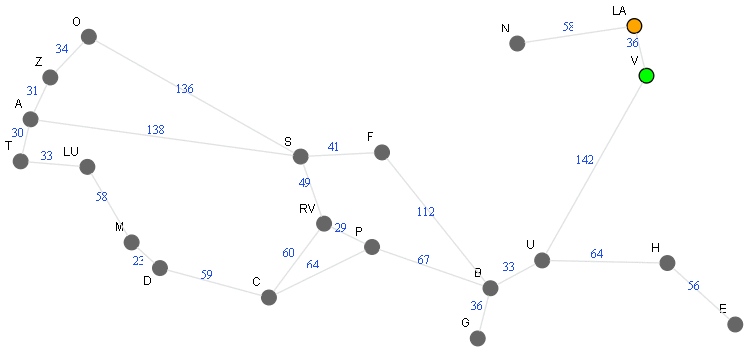

In [4]:
from queue import PriorityQueue
from docHelpers_ipython import romania_location_map
from math import floor
import geopy

# VISUALIZATION PURPOSE
from docHelpers_ipython import Doc 
from IPython.display import display, Image

cameFrom = { }  

# NEEDED FUNCTION TO CALCULATE DISTANCE FROM CURRENT NODE BACK TO START
def totalDistance(current_node):
    cost = 0
    while current_node is not None:
        parent = cameFrom.get(current_node, None)
        if parent is not None:
            cost += distance(current_node, parent)
        current_node = parent
    return cost

def distance(start_node, end_node):

    (x0,y0) = M[start_node]['pos']
    (x1,y1) = M[end_node]['pos']
    return floor(geopy.distance.geodesic((y0,x0), (y1,x1)).miles)

def reconstructPath(current_node):
    Path = [current_node]
    while current_node is not None:
        current_node = cameFrom[current_node] 
        Path.append(current_node)
    return reversed(Path[:-1])   

def AStar(start, goal): 

    # INITIALIZATION
    openSet = PriorityQueue()
    openSet.put((0,start))  
    closedSet = set(start)
    cameFrom[start] = None               
    
    # MAIN LOOP
    while not openSet.empty(): 

        current_cost, current_node = openSet.get()     

        if current_node is goal:   
            print('Success. Route from {} to {} found. Cost: {} Path: {}'.format(start,goal,current_cost,list(reconstructPath(current_node))))
            break
            
        # VISUALIZATION PURPOSE
        all_neighbors = reversed(M.get(current_node,[]).get('connections',[]))        
        considered_neighbors = list(set(all_neighbors) - set(closedSet)) # thank you: https://stackoverflow.com/questions/3462143/get-difference-between-two-lists                               
            
        all_neighbors = M.get(current_node,[]).get('connections',[]) 
        for each_neighbor in all_neighbors: 
            
            gScore = totalDistance(current_node) + distance(current_node,each_neighbor) 
            
            if each_neighbor in closedSet:  # Better parent sub algorithm?!!
            
                tentative_gScore = totalDistance(each_neighbor) # neighbor already in closed set, so there is previous parent for sure                
                if (gScore >= tentative_gScore): # current_node is better parent for this neighbor
                    continue                                        
            
            else:  
                
                hScore = distance(each_neighbor, goal)
                fScore = gScore + hScore                
                openSet.put((fScore, each_neighbor))     
                
                closedSet.add(each_neighbor)
                
            cameFrom[each_neighbor] = current_node # if we didn't 'continue', this has to happen anways visited or not
            # VISUALIZATION PURPOSE
            _ = doc.updateParent(each_neighbor, current_node)        
        
        # VISUALIZATION PURPOSE
        _ = doc.computeGraphs(current_node, considered_neighbors)        
        #print(openSet.queue)  #just to verify
                
    # VISUALIZATION PURPOSE
    _ = doc.computeGraphs(current_node, [])            
    return 'No Goal found!'
            
            
M = romania_location_map 
start = 'V'
goal = 'C'

# VISUALIZATION PURPOSE - called here caz we use doc in ourSearchAlgo
doc = Doc(M) 

result = AStar(start, goal)

# VISUALIZATION PURPOSE
images = doc.render()
display(Image(images[0]),Image(images[1]),Image(images[2]))

As some of you might have predicted, this is the problem with our map dictionary. Currently it is as below

```python
romania_location_map = {
    'A' : {'pos': (21.31227,46.18656), 'connections': ['S','T','Z'] },
    'S' : {'pos': (24.12558,45.79833), 'connections': ['F','RV','O'] },
    'Z' : {'pos': (21.51742,46.62251), 'connections': ['O'] },
    'T' : {'pos': (21.20868,45.74887), 'connections': ['LU'] },
    'O' : {'pos': (21.91894,47.04650), 'connections': [] },
    'F' : {'pos': (24.97310,45.84164), 'connections': ['B'] },
    'LU' : {'pos': (21.90346,45.69099), 'connections': ['M'] },
    'RV' : {'pos': (24.36932,45.09968), 'connections': ['C','P'] },
    'M' : {'pos': (22.36452,44.90411), 'connections': ['D'] },
    'D' : {'pos': (22.65973,44.63692), 'connections': ['C'] },
    'C' : {'pos': (23.79488,44.33018), 'connections': [] },
    'P' : {'pos': (24.86918,44.85648), 'connections': ['B','C'] },
    'B' : {'pos': (26.10254,44.42677), 'connections': ['G','U'] },
    'G' : {'pos': (25.96993,43.90371), 'connections': [] },
    'U' : {'pos': (26.64112,44.71653), 'connections': ['H','V'] },
    'V' : {'pos': (27.72765,46.64069), 'connections': ['LA'] },
    'LA' : {'pos':(27.60144,47.15845), 'connections': ['N'] },
    'N' : {'pos': (26.38188,46.97587), 'connections': [] },
    'H' : {'pos': (27.94566,44.68935), 'connections': ['E'] },
    'E' : {'pos': (28.65273,44.04911), 'connections': [] }
}
```
As per above map, only 'LA' is connected to 'V' and 'N' to 'LA'.

```python
    'V' : {'pos': (27.72765,46.64069), 'connections': ['LA'] },
    'LA' : {'pos':(27.60144,47.15845), 'connections': ['N'] },
```

Our map dictionary was good enough to construct and visualize a graph, but as such, in raw form, it is not a complete description. ```Graphviz```, the library we used to draw above graphs, took care of closing gaps, and inter connecting, but raw dictionary is by itself, insufficient to describe our graph adequately. 

Now, one could go ahead and update the above dictionary (for eg, to include 'U' as well in connections of 'V', but this could be confusing and time consuming to make a complete graph. 

What we could instead do is, just like how graphviz made a complete graph out of this raw description, we will use another library called ```networkx```, which can be useful for ```graph analysis```

With that library, it would suffice if we just feed this raw form, and it takes care of incomplete details like 'U' inturn connected back to 'V' etc. 

## Networkx

Below is a small snippet with which we could construct the graph object from our map description. 

In [7]:
import networkx as nx


def getNetworkxGraph(Map):
    nG = nx.Graph()
    for node in Map.keys():
        nG.add_node(node, pos=Map[node]['pos'])
    for node in Map.keys():
        for con_node in Map[node]['connections']:
            nG.add_edge(node, con_node)   

    return nG

M = getNetworkxGraph(romania_location_map)

Then we could access the neigbors of any node very easily.. Lets check out for ```'V'``` which created the problem earlier..

In [9]:
list(M.neighbors('V'))

['U', 'LA']

As you can see, now not just ```'LA'```, we also got ```'U'``` automatically, even though we did not have that under ```connections``` for ```'V'``` directly.  

Now our algorithm should have no problem accessing in the other direction as well. Let us check it out, integrating this change. Firstly the one without visualization (as viz brings its own complications)

Note, change is also needed in distance function, as earlier we sent dict, but now networkx.

## That's almost all, folks
With this change, we are almost done with Search algorithms. 

In [20]:
from queue import PriorityQueue
from docHelpers_ipython import romania_location_map
from math import floor
import geopy
import networkx as nx


def getNetworkxGraph(Map):
    nG = nx.Graph()
    for node in Map.keys():
        nG.add_node(node, pos=Map[node]['pos'])
    for node in Map.keys():
        for con_node in Map[node]['connections']:
            nG.add_edge(node, con_node)   

    return nG

cameFrom = { }  

# NEEDED FUNCTION TO CALCULATE DISTANCE FROM CURRENT NODE BACK TO START
def totalDistance(current_node):
    cost = 0
    while current_node is not None:
        parent = cameFrom.get(current_node, None)
        if parent is not None:
            cost += distance(current_node, parent)
        current_node = parent
    return cost

def distance(start_node, end_node):

    (x0,y0) = M.node[start_node]['pos']  # changed to M.node as its networkx now
    (x1,y1) = M.node[end_node]['pos']
    return floor(geopy.distance.geodesic((y0,x0), (y1,x1)).miles)

def reconstructPath(current_node):
    Path = [current_node]
    while current_node is not None:
        current_node = cameFrom[current_node] 
        Path.append(current_node)
    return reversed(Path[:-1])   

def AStar(start, goal): 

    # INITIALIZATION
    openSet = PriorityQueue()
    openSet.put((0,start))  
    closedSet = set(start)
    cameFrom[start] = None               
    
    # MAIN LOOP
    while not openSet.empty(): 

        current_cost, current_node = openSet.get()     

        if current_node is goal:   
            print('Success. Route from {} to {} found. Cost: {} Path: {}'.format(start,goal,current_cost,list(reconstructPath(current_node))))
            break
            
        all_neighbors = M.neighbors(current_node)  # easier and safer to get neighbors
        for each_neighbor in all_neighbors: 
            
            gScore = totalDistance(current_node) + distance(current_node,each_neighbor) 
            
            if each_neighbor in closedSet:  
            
                tentative_gScore = totalDistance(each_neighbor) 
                if (gScore >= tentative_gScore): 
                    continue                                        
            
            else:  
                
                hScore = distance(each_neighbor, goal)
                fScore = gScore + hScore                
                openSet.put((fScore, each_neighbor))     
                
                closedSet.add(each_neighbor)
                
            cameFrom[each_neighbor] = current_node 
                
        #print(openSet.queue)  #just to verify
                
            
    return 'No Goal found!'
            
            
M = getNetworkxGraph(romania_location_map )  # passing on networkx object
start = 'V'
goal = 'C'
result = AStar(start, goal)

Success. Route from V to C found. Cost: 306 Path: ['V', 'U', 'B', 'P', 'C']


## Visualization (Optional)

Success. Route from V to C found. Cost: 306 Path: ['V', 'U', 'B', 'P', 'C']


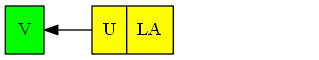

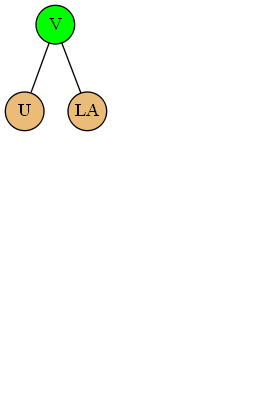

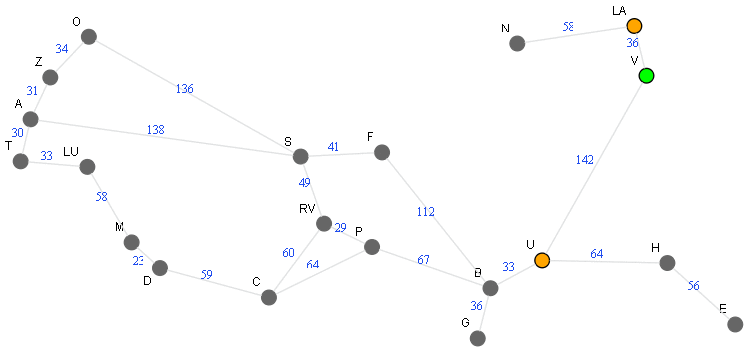

In [22]:
from queue import PriorityQueue
from docHelpers_ipython import romania_location_map
from math import floor
import geopy
import networkx as nx


def getNetworkxGraph(Map):
    nG = nx.Graph()
    for node in Map.keys():
        nG.add_node(node, pos=Map[node]['pos'])
    for node in Map.keys():
        for con_node in Map[node]['connections']:
            nG.add_edge(node, con_node)   

    return nG

# VISUALIZATION PURPOSE
from docHelpers_ipython import Doc 
from IPython.display import display, Image

cameFrom = { }  

# NEEDED FUNCTION TO CALCULATE DISTANCE FROM CURRENT NODE BACK TO START
def totalDistance(current_node):
    cost = 0
    while current_node is not None:
        parent = cameFrom.get(current_node, None)
        if parent is not None:
            cost += distance(current_node, parent)
        current_node = parent
    return cost

def distance(start_node, end_node):

    (x0,y0) = M.node[start_node]['pos']
    (x1,y1) = M.node[end_node]['pos']
    return floor(geopy.distance.geodesic((y0,x0), (y1,x1)).miles)

def reconstructPath(current_node):
    Path = [current_node]
    while current_node is not None:
        current_node = cameFrom[current_node] 
        Path.append(current_node)
    return reversed(Path[:-1])   

def AStar(start, goal): 

    # INITIALIZATION
    openSet = PriorityQueue()
    openSet.put((0,start))  
    closedSet = set(start)
    cameFrom[start] = None               
    
    # MAIN LOOP
    while not openSet.empty(): 

        current_cost, current_node = openSet.get()     

        if current_node is goal:   
            print('Success. Route from {} to {} found. Cost: {} Path: {}'.format(start,goal,current_cost,list(reconstructPath(current_node))))
            break
            
        # VISUALIZATION PURPOSE
        all_neighbors = M.neighbors(current_node)        
        considered_neighbors = list(set(all_neighbors) - set(closedSet)) # thank you: https://stackoverflow.com/questions/3462143/get-difference-between-two-lists                               
            
        all_neighbors = M.neighbors(current_node) 
        for each_neighbor in all_neighbors: 
            
            gScore = totalDistance(current_node) + distance(current_node,each_neighbor) 
            
            if each_neighbor in closedSet:  # Better parent sub algorithm?!!
            
                tentative_gScore = totalDistance(each_neighbor) # neighbor already in closed set, so there is previous parent for sure                
                if (gScore >= tentative_gScore): # current_node is better parent for this neighbor
                    continue                                        
            
            else:  
                
                hScore = distance(each_neighbor, goal)
                fScore = gScore + hScore                
                openSet.put((fScore, each_neighbor))     
                
                closedSet.add(each_neighbor)
                
            cameFrom[each_neighbor] = current_node # if we didn't 'continue', this has to happen anways visited or not
            # VISUALIZATION PURPOSE
            _ = doc.updateParent(each_neighbor, current_node)        
        
        # VISUALIZATION PURPOSE
        _ = doc.computeGraphs(current_node, considered_neighbors)        
        #print(openSet.queue)  #just to verify
                
    # VISUALIZATION PURPOSE
    _ = doc.computeGraphs(current_node, [])            
    return 'No Goal found!'
            
            
Mraw = romania_location_map 
M = getNetworkxGraph(Mraw)
start = 'V'
goal = 'C'

# VISUALIZATION PURPOSE - called here caz we use doc in ourSearchAlgo
doc = Doc(Mraw) 

result = AStar(start, goal)

# VISUALIZATION PURPOSE
images = doc.render()
display(Image(images[0]),Image(images[1]),Image(images[2]))

It works  :)

<font color=blue>Try out the same changes for our earlier algorithms: UCS, DFS and BFS. </font>

Hope you enjoyed the series. I had to make it so detailed, as it is very easy to forget the roles of the constructs in the algorithm. While it may be easy to memorize, that would not last long, and not a strong foundation. You need to know why each and every step exits, its purpose, problem it solves etc for a stronger foundation. 

Once we have that, it would be easier to learn advanced concepts on top of these foundations.